0. **[Stuff](#0.-Stuff)**<br>
    0.1 [About the notebook](#0.1-About-the-notebook)<br>
    0.2 [Imports](#0.2-Imports)<br>
1. **[Functions to fit the top PMT array](#1.-Functions-to-fit-the-top-PMT-array)**<br>
2. **[Functions to fit the bottom PMT](#2.-Functions-to-fit-the-bottom-PMT)**<br>
3. **[Pushing gaindoc to database](#3.-Pushing-gaindoc-to-database)**<br>
    3.1 [Merge gaindocs](#3.1-Merge-gaindocs)<br>
    3.2 [Push to database](#3.2-Push-to-database)<br>
4. **[Playground](#4.-Playground)**<br>
    4.1 [Find peak in trigger window](#4.1-Find-peak-in-trigger-window)<br>

# 0. Stuff

## 0.1 About this notebook

This notebook serves for LED calibration WITH an amplifier attached. The top PMTs are decoupled from the bottom PMT to guarantee a proper LED calibration. Therefore two LED runs with two different pulser settings are necesary.
The gaindocs are merged afterwards and can be pushed or updated to the database

## 0.2 Imports

In [16]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
from scipy.optimize import curve_fit
import straxbra
from pymongo import MongoClient
import os
import strax
import json
import patrick_stylez as ps

In [17]:
ctx = straxbra.XebraContext(register=[straxbra.plugins.DAQReader],
                            config={'do_breaks' : False})

# 1. Functions to fit the top PMT array

In [14]:
def gaus(x, h, mu, sigma):

    gaus = h * np.exp(-(x-mu)**2         /(2*sigma**2))
    return gaus
    

def fit_fcn(x, h_bgd, mu_bgd, sigma_bgd,h_uae, mu_uae, sigma_uae, h_spe, mu_spe, sigma_spe, h_dpe):
        background =    h_bgd             * np.exp(-(x - mu_bgd) ** 2        / (2 * sigma_bgd ** 2))
        uae =           h_uae             * np.exp(-(x - mu_uae) ** 2        / (2 * sigma_uae ** 2))
        spe =           h_spe             * np.exp(-(x - mu_spe) ** 2        / (2 * sigma_spe ** 2))
        dpe =           h_dpe             * np.exp(-(x - 2 * mu_spe) ** 2    / (2 * 2 * sigma_spe ** 2))
        fit_function = background + uae + spe + dpe
        return fit_function

def fit_fcn3(x, h_bgd, mu_bgd, sigma_bgd,h_uae, mu_uae, sigma_uae, h_spe, mu_spe, sigma_spe):
        background =    h_bgd             * np.exp(-(x - mu_bgd) ** 2        / (2 * sigma_bgd ** 2))
        uae =           h_uae             * np.exp(-(x - mu_uae) ** 2        / (2 * sigma_uae ** 2))
        spe =           h_spe             * np.exp(-(x - mu_spe) ** 2        / (2 * sigma_spe ** 2))

        fit_function_3 = background + uae + spe
        return fit_function_3

def PlotTop(context, run):
    fig, axs = plt.subplots(figsize=(18,12), nrows=3, ncols=3)
#     raw = ctx.get_array(run, 'raw_records')
    window_low = 40
    window_high = 65

    gains_top = {
        'bin_centers' : [],
        'histogram' : [],
        'popt' : [],
        'pcov' : [],
        'adc_to_pe' : [],
        'gain' : [],
        'run' : int(run),
    }

    adc_to_e = (2.25/2**14) * (1e-8) * (1/50) * (1/1.602e-19) * 10
    adc_to_pe = (2.25/2**14) * (1e-8) * (1/50) * (1/1.602e-19) * (1/10)

    gain_list_top = []
    error_list_top = []
    gain_in_adc_counts_bot = []
    for ch in list(range(1,8)):
        if (ch==1 or ch == 6):
            bin_high =1250
        if (ch == 2 or ch == 4):
            bin_high = 1550
        if (ch == 3 or ch == 7):
            bin_high = 2150
        if ch == 5:
            bin_high = 950 
            
        num_bins = int((bin_high+100)/3)


        bins = np.linspace(-100,bin_high,num_bins)
        bin_widths = bins[1:] - bins[:-1]
        bin_centers = 0.5*(bins[1:] + bins[:-1])
        ax = axs[ch//3][ch%3]
        n, _ = np.histogram(raw['data'][raw['channel'] == ch,window_low:window_high].sum(axis=1), bins=bins)
        sigma = np.maximum(np.ones_like(n), np.sqrt(n)/bin_widths)
        n = n/bin_widths
        gains_top['bin_centers'].append(bin_centers.tolist())
        gains_top['histogram'].append(n.tolist())
        cts = n.sum()
        
        
        mu_bkg_index = np.argmax(n)  
        mu_bkg = bin_centers[mu_bkg_index]
        h_bkg = n[mu_bkg_index]                            
        sigma_bkg = 0
        for i in n[mu_bkg_index:]:
            if i < h_bkg * 0.5:
                
                FWHM = np.abs(
                    bin_centers[np.where(n[mu_bkg_index:] ==i) + mu_bkg_index] - bin_centers[np.where(n[mu_bkg_index:] == h_bkg)+ mu_bkg_index])*2
                sigma_bkg +=FWHM / (2 * np.sqrt(2 * np.log(2)))
                #print(n[mu_bgd_index:].index(h_bgd))
                break

        if ch == 2:    
            valley = np.argmin(n[10:len(bins)//2])
            mu_spe_index = np.argmax(n[valley:len(bins)])+valley
            mu_spe = bin_centers[mu_spe_index]
        elif ch == 3:
            mu_spe_index = np.argmax(n[len(bins)//4 :]) + len(bins)//4 
            mu_spe = bin_centers[mu_spe_index]
        else:
            mu_spe_index = np.argmax(n[len(bins)//5 :]) + len(bins)//5
            mu_spe = bin_centers[mu_spe_index]
            
        h_spe = n[mu_spe_index]
        mu_uae = mu_spe/2
        h_dpe = 0.1*h_spe


        p0 = [h_bkg, mu_bkg, sigma_bkg,       10, mu_uae, 50,      h_spe, mu_spe, sigma_bkg ]

        bounds_PMT_top = ((0, -50, 0,                    0, 0.3*mu_uae, 0,             0, 0.5*mu_spe , 0), 
              (       np.inf, np.inf, np.inf,             np.inf,1.2*mu_uae, 3*sigma_bkg,       np.inf, 1.5*mu_spe, np.inf))
        
        bounds_PMT_top_ch5 = ((0, -50, 0,                    0, mu_bkg, 0,             0, 0.5*mu_spe , 0), 
              (       np.inf, np.inf, np.inf,             np.inf,mu_spe, 3*sigma_bkg,       np.inf, 1.5*mu_spe, np.inf))
        

        if ch == 5:
            try:
                popt, pcov = curve_fit(fit_fcn3, bin_centers, n, p0=p0,bounds =bounds_PMT_top_ch5,sigma=sigma, maxfev = 20000)
                perr = np.sqrt(np.diag(pcov))
                ax.plot(bin_centers, (fit_fcn3(bin_centers, *popt)), 'b-') 
                ax.plot(bin_centers, n, c='k', alpha = 0.5)
                ax.plot(bin_centers, (gaus(bin_centers, popt[0], popt[1], popt[2])), 'g--', label='bkg peak')
                ax.plot(bin_centers, (gaus(bin_centers, popt[3], popt[4], popt[5])), 'y--', label='uae peak')
                ax.plot(bin_centers, (gaus(bin_centers, popt[6], popt[7], popt[8])), 'm--', label='spe peak')
                gains_top['popt'].append(popt.tolist())
                gains_top['pcov'].append(pcov.tolist())
                gains_top['adc_to_pe'].append(1./popt[7])
                gains_top['gain'].append(popt[7]*adc_to_e)

                gain_in_adc_counts_bot.append(popt[7])
                gain_list_top.append(popt[7]*adc_to_pe)
                error_list_top.append(perr[7]*adc_to_pe)  
            except Exception as e:
                print('CH%i failed\n' % ch)
        else:

            try:
                popt, pcov = curve_fit(fit_fcn3, bin_centers, n, p0=p0,bounds =bounds_PMT_top,sigma=sigma, maxfev = 20000)
                perr = np.sqrt(np.diag(pcov))
                ax.plot(bin_centers, (fit_fcn3(bin_centers, *popt)), 'b-')
                ax.plot(bin_centers, n, c='k', alpha = 0.5)
                ax.plot(bin_centers, (gaus(bin_centers, popt[0], popt[1], popt[2])), 'g--', label='bkg peak')
                ax.plot(bin_centers, (gaus(bin_centers, popt[3], popt[4], popt[5])), 'y--', label='uae peak')
                ax.plot(bin_centers, (gaus(bin_centers, popt[6], popt[7], popt[8])), 'm--', label='spe peak')
                gains_top['popt'].append(popt.tolist())
                gains_top['pcov'].append(pcov.tolist())
                gains_top['adc_to_pe'].append(1./popt[7])
                gains_top['gain'].append(popt[7]*adc_to_e)

                gain_in_adc_counts_bot.append(popt[7])
                gain_list_top.append(popt[7]*adc_to_pe)
                error_list_top.append(perr[7]*adc_to_pe)
            except Exception as e:
                print('CH%i failed\n' % ch)

        ax.set_ylim([1,None])
        ax.legend()
        ax.set_yscale('log')

    plt.show()
    return gains_top

## Run this to get gaindoc_top and to check how the fits look like

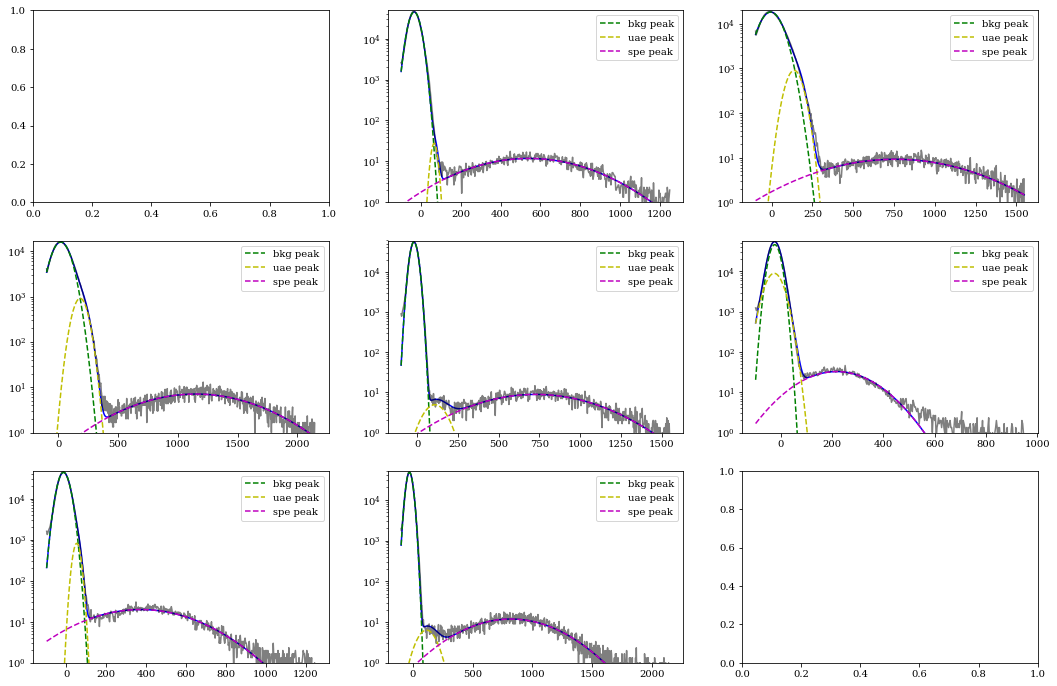

In [15]:
run = '00130'
raw = ctx.get_array(run, 'raw_records')
gaindoc_top = PlotTop(ctx,run)

# 2. Functions to fit the bottom PMT

In [5]:
def fit_fcn_bot(x, h_bgd, mu_bgd, sigma_bgd,h_uae, mu_uae, sigma_uae, h_spe, mu_spe, sigma_spe, h_dpe, h_tpe, h_qpe):
        background =    h_bgd             * np.exp(-(x - mu_bgd) ** 2        / (2 * sigma_bgd ** 2))
        uae =           h_uae             * np.exp(-(x - mu_uae) ** 2        / (2 * sigma_uae ** 2))
        spe =           h_spe             * np.exp(-(x - mu_spe) ** 2        / (2 * sigma_spe ** 2))
        dpe =           h_dpe             * np.exp(-(x - 2 * mu_spe) ** 2    / (2 * 2 * sigma_spe ** 2))
        tpe =           h_tpe             * np.exp(-(x - 3 * mu_spe) ** 2    / (3 * 2 * sigma_spe ** 2))
        qpe =           h_qpe             * np.exp(-(x - 4 * mu_spe) ** 2    / (4 * 2 * sigma_spe ** 2))
        fit_function_bot = background + uae + spe + dpe + tpe + qpe
        return fit_function_bot


def PlotBot(context, run):
    fig, ax = plt.subplots(figsize=(18,12))
#     raw = ctx.get_array(run, 'raw_records')
    window_low = 40
    window_high = 65
    adc_to_e = (2.25/2**14) * (1e-8) * (1/50) * (1/1.602e-19) * 10
    adc_to_pe = (2.25/2**14) * (1e-8) * (1/50) * (1/1.602e-19) * (1/10)
    colors = ['red', 'green', 'cyan', 'magenta', 'lime', 'orange']
    
    gains_bot = {
        'bin_centers' : [],
        'histogram' : [],
        'popt' : [],
        'pcov' : [],
        'adc_to_pe' : [],
        'gain' : [],
        'run' : int(run),
    }

    gain_list_bot = []
    error_list_bot = []
    gain_in_adc_counts_bot = []
    
    bin_high = 1250          
    num_bins = int((bin_high+100)/3)
    bins = np.linspace(-100,bin_high,num_bins)
    bin_widths = bins[1:] - bins[:-1]
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    n, _ = np.histogram(raw['data'][raw['channel'] == 0,window_low:window_high].sum(axis=1), bins=bins)
    sigma = np.maximum(np.ones_like(n), np.sqrt(n)/bin_widths)
    n = n/bin_widths
    gains_bot['bin_centers'].append(bin_centers.tolist())
    gains_bot['histogram'].append(n.tolist())
    mu_bkg_index = np.argmax(n)  
    mu_bkg = bin_centers[mu_bkg_index]
    h_bkg = n[mu_bkg_index]                            
    sigma_bkg = 0
    for i in n[mu_bkg_index:]:
        if i < h_bkg * 0.5:
                
            FWHM = np.abs(
                bin_centers[np.where(n[mu_bkg_index:] ==i) + mu_bkg_index] - bin_centers[np.where(n[mu_bkg_index:] == h_bkg)+ mu_bkg_index])*2
            sigma_bkg +=FWHM / (2 * np.sqrt(2 * np.log(2)))
            break

        
    mu_spe_index = np.argmax(n[len(bins)//4 :]) + len(bins)//4 
    mu_spe = bin_centers[mu_spe_index]
    h_spe = n[mu_spe_index]
    mu_uae = mu_spe/2
    h_dpe = 0.1*h_spe
    h_tpe = 0.5*h_dpe
    h_qpe = 0.5*h_tpe

    p0 = [h_bkg, mu_bkg, sigma_bkg,                     100, mu_uae, 50,                       h_spe, mu_spe, sigma_bkg,         h_dpe,  h_tpe, h_qpe ]
    bounds = ((0, -50, 0.5*sigma_bkg,                   0, mu_bkg, 0.3*sigma_bkg,              mu_uae, mu_uae, 0.3*sigma_bkg,    h_tpe,         0,0), 
              (np.inf, np.inf, 1.5*sigma_bkg,           h_spe, mu_spe, 2*sigma_bkg,            np.inf, np.inf, 4*sigma_bkg,    h_spe, h_dpe, np.inf))
       
    print(mu_spe)
    
    
#     popt, pcov = curve_fit(fit_fcn_bot, bin_centers, n,p0=p0,bounds =bounds,sigma=sigma, maxfev = 10000)
#     perr = np.sqrt(np.diag(pcov))
#     ax.plot(bin_centers, n, c='k', alpha = 0.5)



    try:
        popt, pcov = curve_fit(fit_fcn_bot, bin_centers, n, p0=p0,bounds =bounds,sigma=sigma, maxfev = 10000)
        perr = np.sqrt(np.diag(pcov))
        ax.plot(bin_centers, (gaus(bin_centers, popt[0], popt[1], popt[2])), 'g--', label='background')
        ax.plot(bin_centers, (gaus(bin_centers, popt[6], popt[7], popt[8])), 'm--', label='single pe')
        ax.plot(bin_centers, (gaus(bin_centers, popt[3], popt[4], popt[5])), 'y--', label='underamplified pe')
        ax.plot(bin_centers, (gaus(bin_centers, popt[9], 2*popt[7], popt[8])), 'k--', label='double pe')
        ax.plot(bin_centers, (gaus(bin_centers, popt[10], 3*popt[7], popt[8])), 'r--', label='triple pe')
        ax.plot(bin_centers, (gaus(bin_centers, popt[11], 4*popt[7], popt[8])), 'c--', label='quadra pe')
        ax.plot(bin_centers, (fit_fcn_bot(bin_centers, *popt)), 'b-')

        ax.plot(bin_centers, n, c='k', alpha = 0.5)

        
        
        gains_bot['popt'].append(popt.tolist())
        gains_bot['pcov'].append(pcov.tolist())
        gains_bot['adc_to_pe'].append(1./popt[7])
        gains_bot['gain'].append(popt[7]*adc_to_e)
        gain_in_adc_counts_bot.append(popt[7])
        gain_list_bot.append(popt[7]*adc_to_pe)
        error_list_bot.append(perr[7]*adc_to_pe)


    except Exception as e:
        print('CH%i failed\n' % 0)



    ax.set_ylim([1,None])
    ax.set_xlim([-20,None])
    ax.legend(loc = 1, prop={'size': 15})
    ax.set_yscale('log')

    plt.show()
    return gains_bot

## Run this to get gaindoc_bot and to check how the fit looks like

238.25167037861914


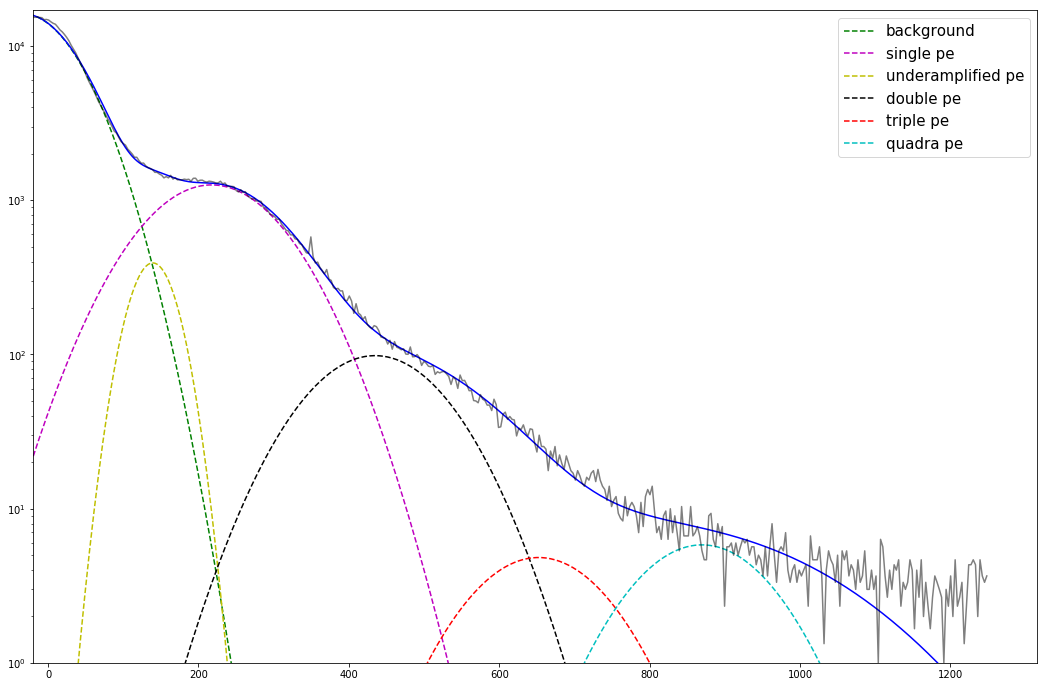

In [6]:
# run = '00130'
# raw = ctx.get_array(run, 'raw_records')
gaindoc_bot = PlotBot(ctx,run)

# 3. Pushing gaindoc to database

## 3.1 Merge gaindocs

In [7]:
def merge(top, bot):

    if isinstance(top, list):
        if len(bot) == 1:
            top.insert(0, bot[0])
        else:
            top.insert(0, bot)
    elif top == bot:
        return top
    else:
        print("ERROR")
        return None
    return top

In [8]:
gaindoc = {a: merge(b, gaindoc_bot[a]) for a,b in gaindoc_top.items()}

## 3.2 Push to database

In [ ]:
# with MongoClient(os.environ['MONGO_DAQ_URI']) as client:
#      client['xebra_daq']['pmt_gains'].insert_one(gaindoc)

In [ ]:
# with MongoClient(os.environ['MONGO_DAQ_URI']) as client:
#     client['xebra_daq']['pmt_gains'].update_one({'run' : 165},{'$set' : {gaindoc}})

# 4. Playground

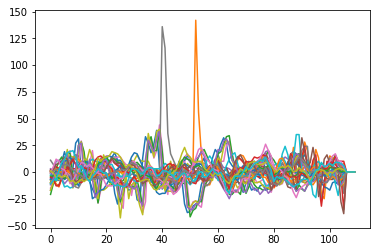

In [9]:
for i in range(20,50):
    plt.plot(raw['data'][raw['channel']==0][i])
# plt.axvline(40, c='r')
# plt.axvline(65, c='r')

In [10]:
data = raw['data'][raw['channel']==0]

In [11]:
peaks = []
values = []
print_counter = 0.0
#for i in range(len(raw['data'][raw['channel']==0])):
for i in range(len(data)):
    for j in data[i]:
        if j >= 50:
            maximum = max(data[i])
            maximum_index = np.where(data[i] == maximum)
#             plt.plot(raw['data'][raw['channel']==0][i])
            peaks.append(maximum_index[0][0])
            values.append(maximum)
            break
    if i/len(data) >= print_counter:
        print(round(print_counter,2), end = ' ')
        print_counter += 0.1
print(1.0, '        Run ',run, 'done!')    

            


0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0         Run  00130 done!


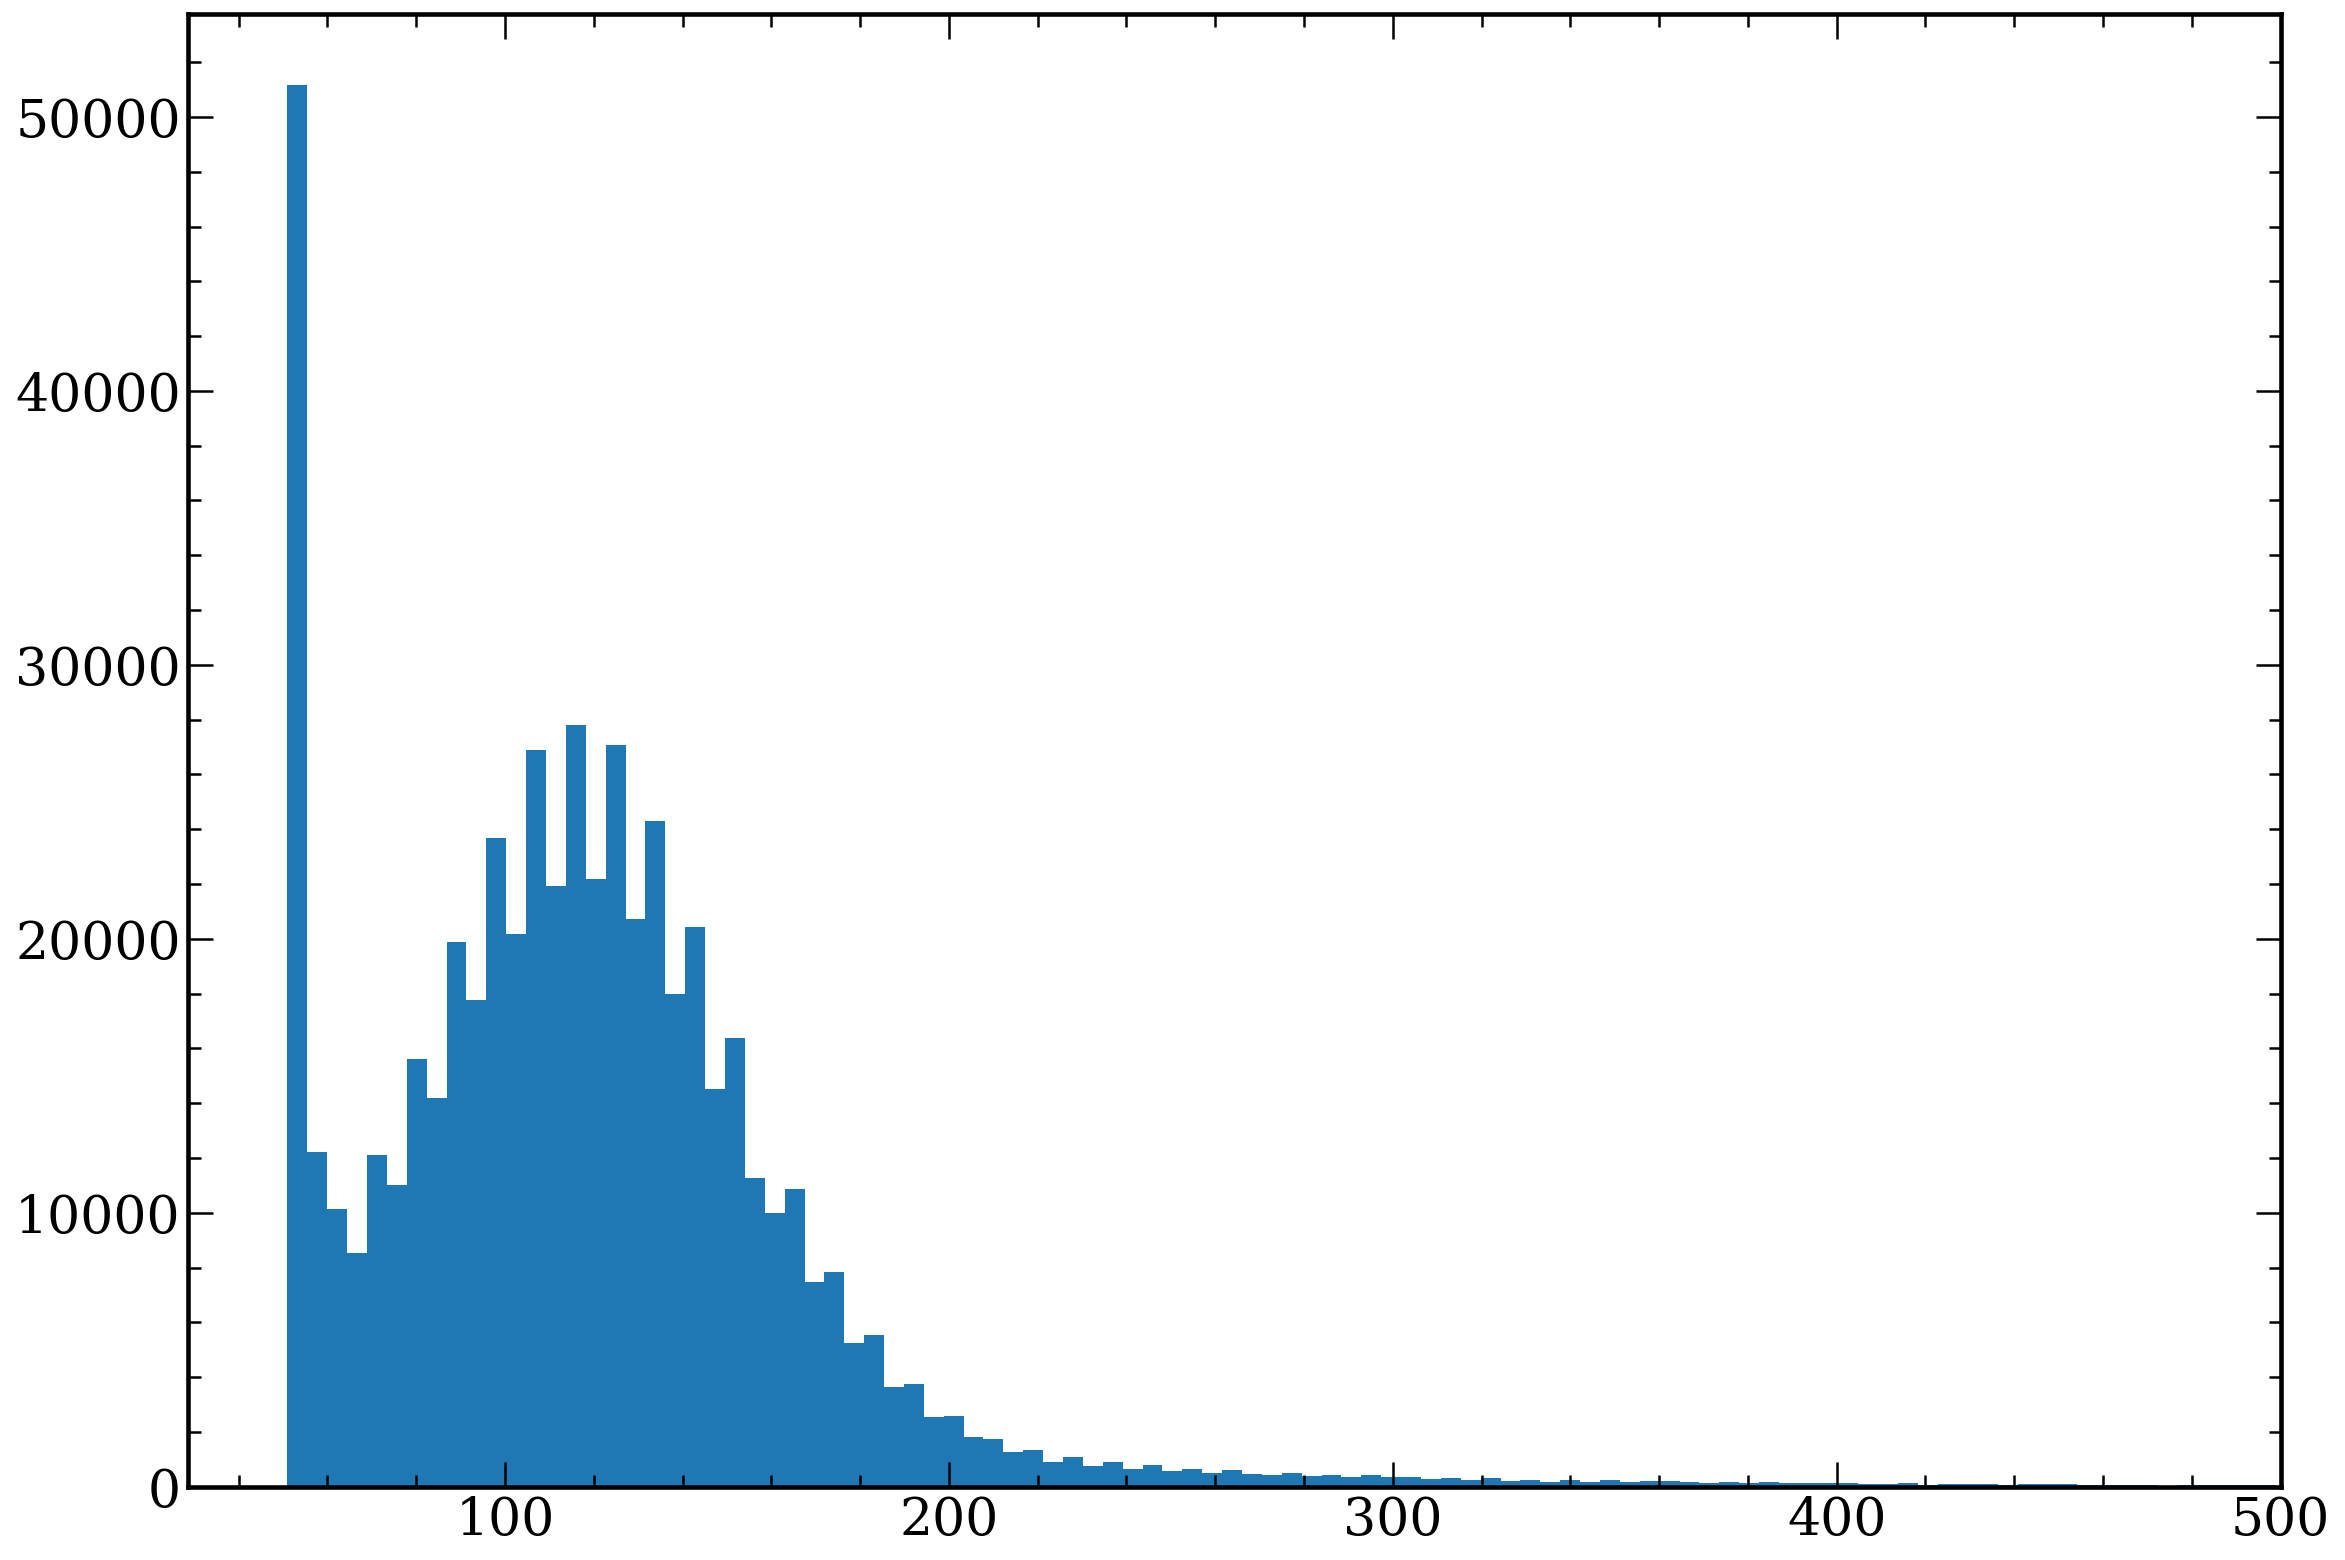

In [12]:
fig,axes = ps.styles()
cut_values = []
for i in values:
    if i < 500 and i > 50:
        cut_values.append(i)
plt.hist(cut_values, bins=100)
axes.set_xlim([None,500])

plt.show()

## 4.1 Find peak in trigger window

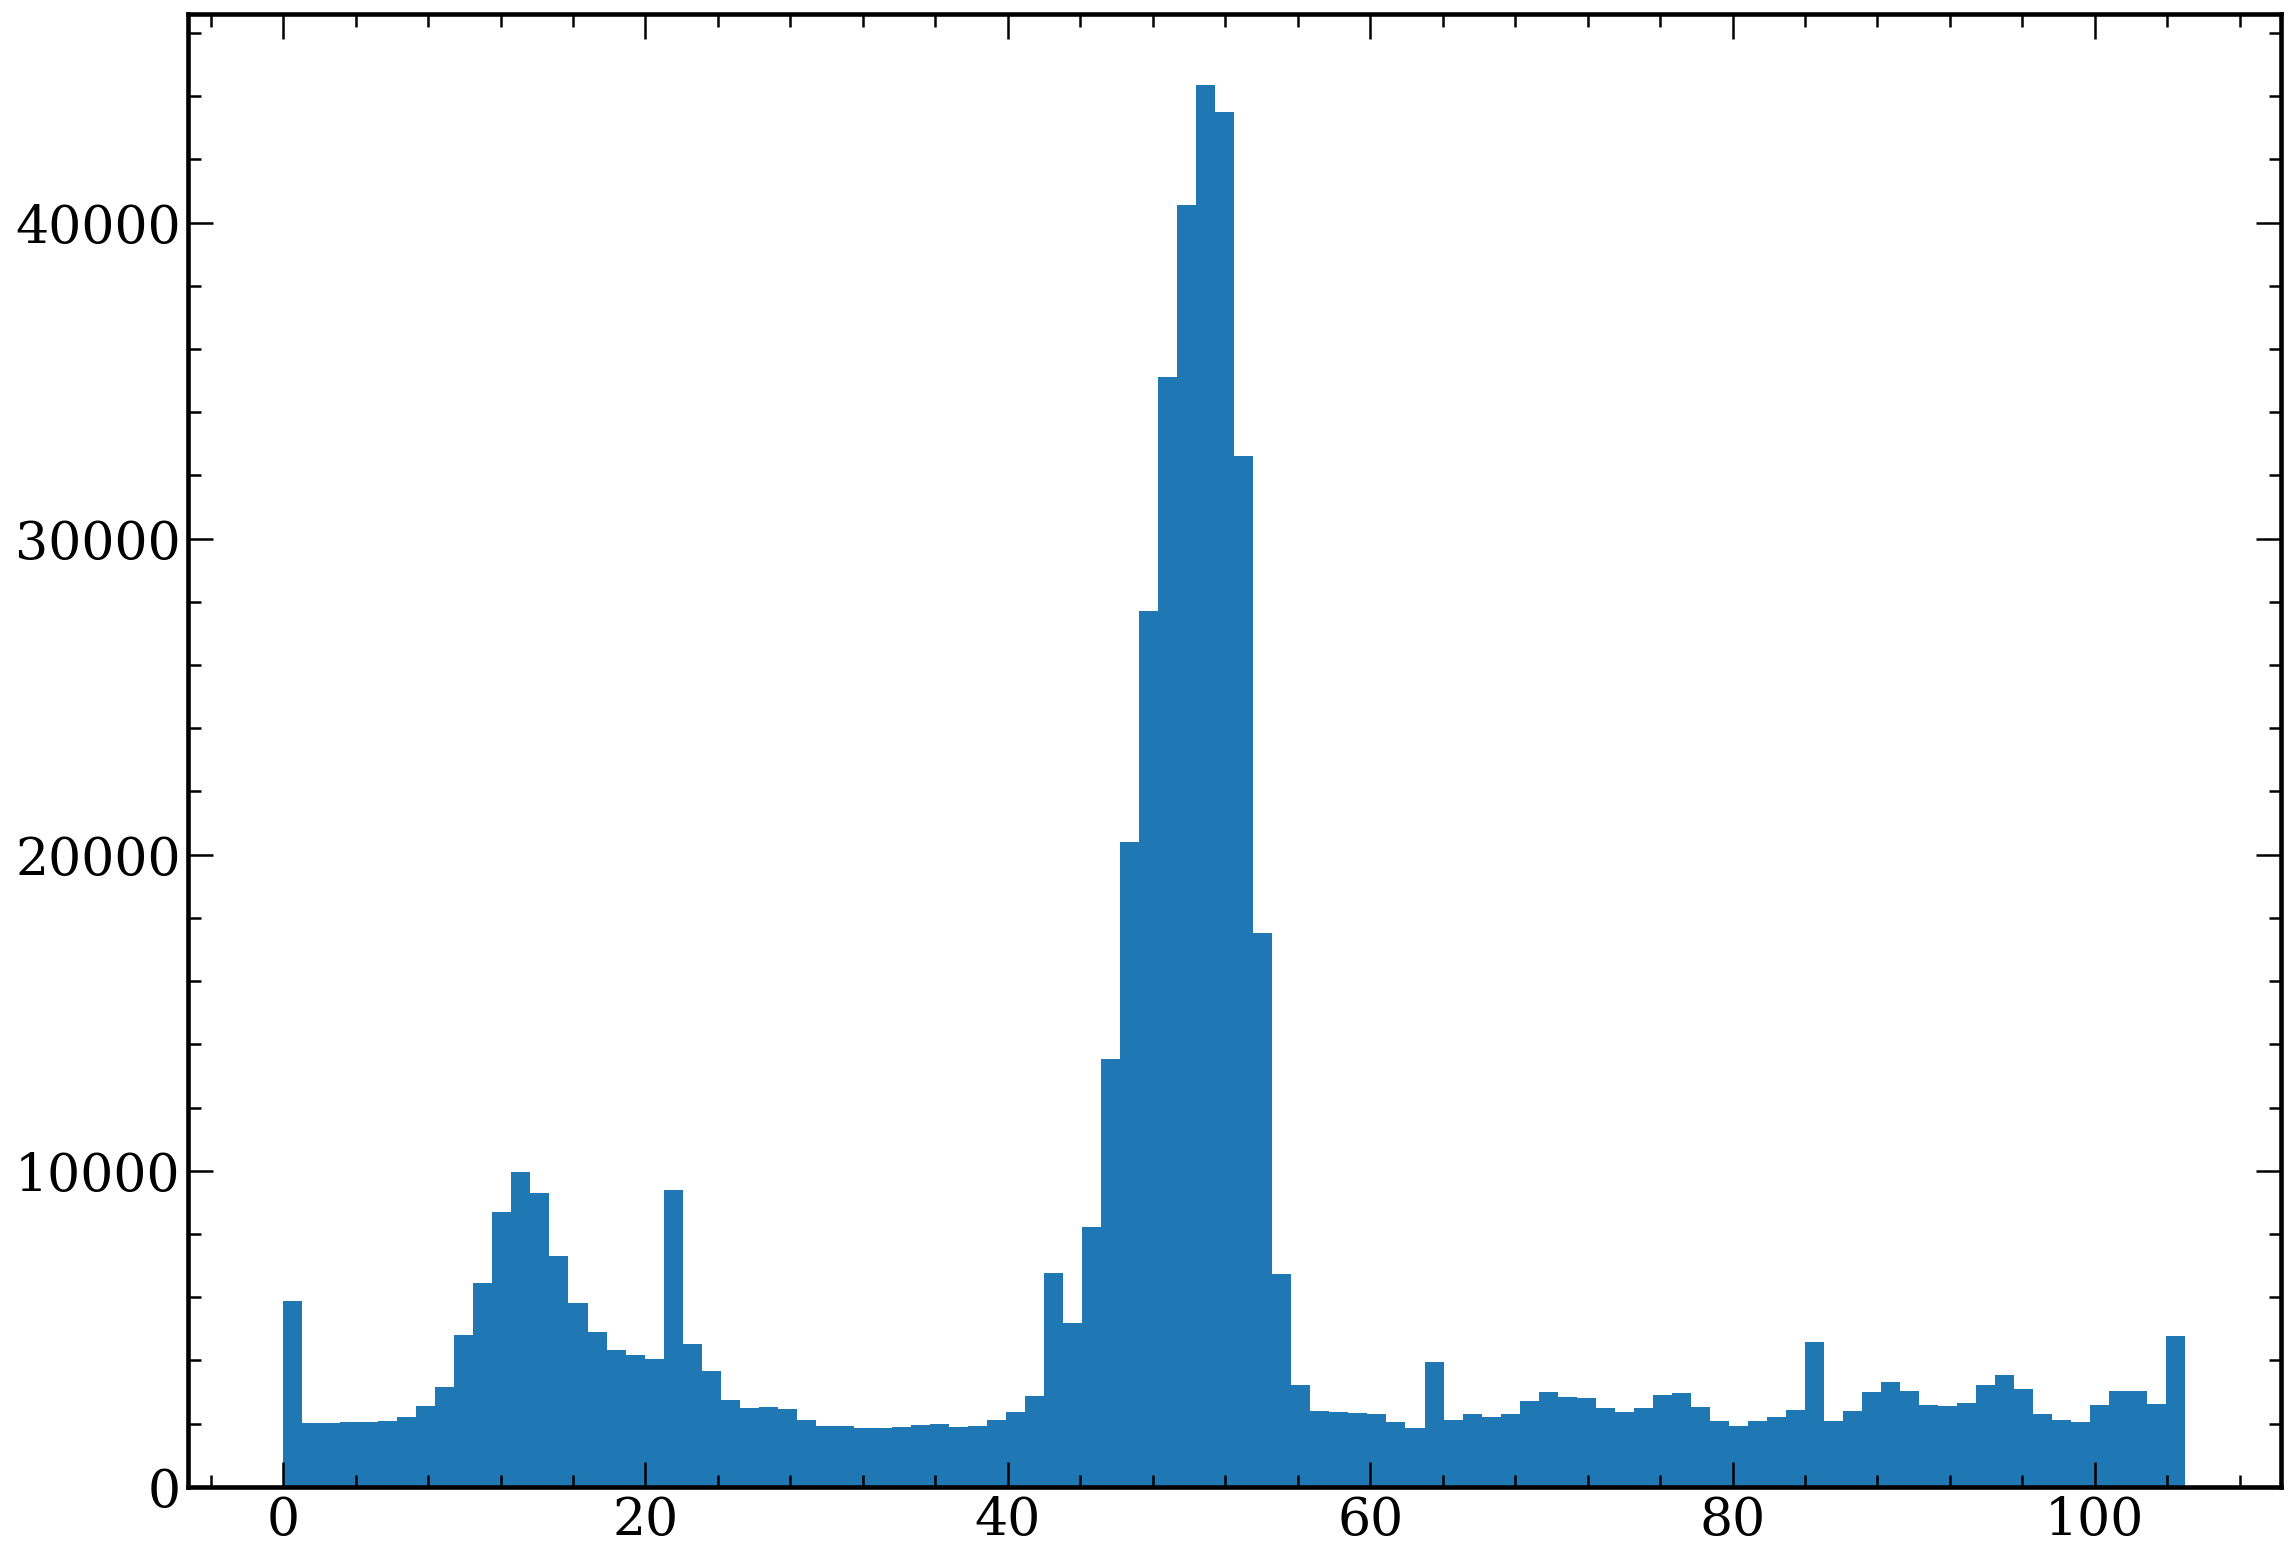

In [13]:
fig,axes = ps.styles()
plt.hist(peaks, bins=100)
plt.show()